<a href="https://colab.research.google.com/github/davidsjohnson/evalxai_studies/blob/main/notebooks/two4two_model_and_data_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pathlib
import os
import sys
from pathlib import Path
import tarfile
import random

import numpy as np

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms

from PIL import Image

torch.backends.cudnn.benchmark = True

In [20]:
torch.__version__

'2.4.0+cpu'

# Params

In [2]:
CLASSES = ['Healthy', 'OC Degeneration']
modeltype = 'mobilenet'
ds = 'sick_ones_bendbias'

# Setup and Load Datasets

In [21]:
# data downloading and dataset utilities

'''def download_file(url, file_name, cache_dir="data", extract=True, force_download=False, archive_folder=None):
    # Ensure the cache directory exists
    os.makedirs(cache_dir, exist_ok=True)
    file_path = os.path.join(cache_dir, file_name)

    # Download the file
    if not os.path.exists(file_path) or force_download:
      torch.hub.download_url_to_file(url, file_path)
      print(f"File downloaded to: {file_path}")
    else:
      print(f"File already exists at: {file_path}")

    if extract:
      with tarfile.open(file_path, "r:gz") as tar:
          tar.extractall(path=cache_dir)
      print(f"File extracted to: {cache_dir}")
      return Path(cache_dir) / archive_folder if archive_folder is not None else Path(cache_dir)

    return Path(file_path)'''

def load_dataframe(data_dir, dataset):
  data_dir = data_dir / dataset
  df = pd.read_json(data_dir / 'parameters.jsonl', lines=True)
  df['filename'] = df['id'] + '.png'
  df['ill'] = df['ill'].astype(int).astype(str)
  return df

class ImageDataset(Dataset):
    def __init__(self, df, data_dir, transform=None):
        self.df = df
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.df.iloc[idx]['filename'])
        image = Image.open(img_path).convert('RGB')
        label = int(self.df.iloc[idx]['ill'])

        if self.transform:
            image = self.transform(image)

        return image, label
    

import os
import torch
import tarfile
from pathlib import Path

def download_file(url, file_name, cache_dir="data", extract=True, force_download=False, archive_folder=None):

    os.makedirs(cache_dir, exist_ok=True)
    file_path = os.path.join(cache_dir, file_name)
    

    if os.path.exists(file_path) and not force_download:
        print(f"File already exists at: {file_path}")
    else:
        torch.hub.download_url_to_file(url, file_path)
        print(f"File downloaded to: {file_path}")


    if extract:
        extract_path = Path(cache_dir) / (archive_folder if archive_folder else "")
        if extract_path.exists() and any(extract_path.iterdir()):  
            print(f"Dataset already extracted at: {extract_path}")
        else:
            with tarfile.open(file_path, "r:gz") as tar:
                tar.extractall(path=cache_dir)
            print(f"File extracted to: {cache_dir}")

        return extract_path

    return Path(file_path)


## Load Dataset and Dataloaders


In [4]:
# download data direcly from sciebo
# (or setup own data location if prefered)

data_dir = download_file(url="https://uni-bielefeld.sciebo.de/s/AIJLvXMwP0ngEiW/download",
                         file_name="two4two_datasets.tar.gz",
                         cache_dir='/content/data', # change this if not using Colab
                         extract=True,
                         force_download=False,
                         archive_folder='two4two_datasets')
data_dir

File already exists at: /content/data\two4two_datasets.tar.gz
Dataset already extracted at: \content\data\two4two_datasets


WindowsPath('/content/data/two4two_datasets')

In [5]:
ds_dir = data_dir / ds
ds_dir

WindowsPath('/content/data/two4two_datasets/sick_ones_bendbias')

In [6]:
# load datasets and dataloaders for pytorch processing
transform = transforms.Compose([
    transforms.ToTensor(),
])


train_df = load_dataframe(ds_dir, 'train')
val_df = load_dataframe(ds_dir, 'validation')
test_df = load_dataframe(ds_dir, 'test')

train_dataset = ImageDataset(train_df, ds_dir / 'train', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                              num_workers=6, pin_memory=True)

val_dataset = ImageDataset(val_df,  ds_dir / 'validation', transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False,
                            num_workers=6, pin_memory=True)

test_dataset = ImageDataset(test_df,  ds_dir / 'test', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                             num_workers=6, pin_memory=True)

# Model Loading and Evaluation





In [22]:
def load_mobilenetv2(num_classes, pretrained=True, checkpoint_path=None):
  """Loads a MobileNetV2 model, optionally loading from a checkpoint.

  Args:
    num_classes: The number of output classes.
    pretrained: Whether to load the pre-trained weights.
    checkpoint_path: Path to a checkpoint file to load.

  Returns:
    A MobileNetV2 model.
  """
  model = models.mobilenet_v2(weights=None if not pretrained else 'DEFAULT')
  model.classifier[1] = nn.Linear(model.last_channel, num_classes)

  if checkpoint_path:
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint)
    print(f"Loaded checkpoint from: {checkpoint_path}")

  return model

In [23]:
def set_seed(seed):
  """
  Sets random seeds for reproducibility.
  """
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False


def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track loss and accuracy
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / len(dataloader)
    accuracy = correct / total

    print(f"Evaluation Loss: {avg_loss:.4f}, Evaluation Accuracy: {accuracy:.4f}")
    return avg_loss, accuracy


In [24]:
checkpoint_path = download_file(url='https://uni-bielefeld.sciebo.de/s/5uQFFsAprXT05in/download',
                                file_name='best_model.pth',
                                cache_dir='/content/model/mobilenetv2_checkpoint', # change this if not using Colab
                                extract=False,
                                force_download=False)
checkpoint_path

File already exists at: /content/model/mobilenetv2_checkpoint\best_model.pth


WindowsPath('/content/model/mobilenetv2_checkpoint/best_model.pth')

In [25]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Evaluate Model

In [26]:
# load best model and evaluate
model = load_mobilenetv2(num_classes=len(CLASSES),
                         pretrained=True,
                         checkpoint_path=checkpoint_path)
model.to(device)

#evaluate_model(model, train_dataloader, criterion, device)
#evaluate_model(model, val_dataloader, criterion, device)
#evaluate_model(model, test_dataloader, criterion, device)

C:\Users\hp 840\AppData\Local\Temp\ipykernel_5912\1887788013.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [27]:
def load_mobilenetv2(num_classes, pretrained=True, checkpoint_path=None):

    model = models.mobilenet_v2(weights=None if not pretrained else 'DEFAULT')
    model.classifier[1] = nn.Linear(model.last_channel, num_classes)

    if checkpoint_path:
        # Load the checkpoint for CPU usage
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
        model.load_state_dict(checkpoint)
        print(f"Loaded checkpoint from: {checkpoint_path}")

    return model

model = load_mobilenetv2(num_classes=len(CLASSES),
                         pretrained=True,
                         checkpoint_path=checkpoint_path)
model.to(device)



Loaded checkpoint from: \content\model\mobilenetv2_checkpoint\best_model.pth


C:\Users\hp 840\AppData\Local\Temp\ipykernel_5912\1438251666.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch.

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
# %cd "C:\Users\hp 840\Downloads\main - Copie - Copie\main\src"
import torch
from utils import prepare_input
from plot import plot_explanations
from plot import plot_explanations
from torchvision import transforms
from utils import prepare_input

from pathlib import Path
from torchvision.models import resnet50, ResNet50_Weights

extracted_dir = Path(data_dir) / "two4two_datasets"

image_path = next(extracted_dir.rglob("*.png"))  #get first png img
print(f"Image path: {image_path}")


_, prepared_input = prepare_input(str(image_path))
prepared_input = prepared_input.float()

transforms = ResNet50_Weights.IMAGENET1K_V1.transforms()




original_image, prepared_input = prepare_input(image_path, transforms=transforms, grayscale=False)
prepared_input = prepared_input.to(device)
prepared_input.requires_grad = True

Image path: \content\data\two4two_datasets\two4two_datasets\sick_ones_bendbias\test\000773b6-93f9-4a21-bbd5-7e4af0c31f74.png


In [ ]:
from explainers import (
    saliency_explainer,
    intgrad_explainer,
    smoothgrad_explainer,
    vargrad_explainer,
    guidedbackprop_explainer
)
from agg_explainers import AGGopt_explainer

pytorch_model = load_mobilenetv2(num_classes=2, pretrained=True)  
wrapped_model = Model(model=pytorch_model, device=device)

# Explainers Initialization 
saliency = saliency_explainer(wrapped_model)
intgrad = intgrad_explainer(wrapped_model)
smoothgrad = smoothgrad_explainer(wrapped_model)
vargrad = vargrad_explainer(wrapped_model)
guidedbp = guidedbackprop_explainer(wrapped_model)

saliency_kwargs = {"abs": True}
intgrad_kwargs = {"baselines": torch.zeros_like(prepared_input)}
smoothgrad_kwargs = {}
vargrad_kwargs = {}

explainers = [saliency, intgrad, smoothgrad, vargrad]
explainers_kwargs = [saliency_kwargs, intgrad_kwargs, smoothgrad_kwargs, vargrad_kwargs]

agg_opt = AGGopt_explainer(wrapped_model, explainers, explainers_kwargs, baseline=None, segments=None)


In [15]:
target_class = 1
explanation_saliency = saliency.explain(prepared_input, target=target_class)
print(f"Saliency Explanation keys: {explanation_saliency.keys()}")

explanation_intgrad = intgrad.explain(prepared_input, target=target_class)
print(f"Integrated Gradients Explanation keys: {explanation_intgrad.keys()}")

explanation_smoothgrad = smoothgrad.explain(prepared_input, target=target_class)
print(f"SmoothGrad Explanation keys: {explanation_smoothgrad.keys()}")

explanation_vargrad = vargrad.explain(prepared_input, target=target_class)
print(f"VarGrad Explanation keys: {explanation_vargrad.keys()}")


explanation_aggopt = agg_opt.explain(prepared_input, target=target_class)
print(f"AGGopt Explanation keys: {explanation_aggopt.keys()}")

Saliency Explanation keys: dict_keys(['saliency'])
Integrated Gradients Explanation keys: dict_keys(['IntGrad'])
SmoothGrad Explanation keys: dict_keys(['SmoothGrad'])
VarGrad Explanation keys: dict_keys(['VarGrad'])


c:\Users\hp 840\Downloads\main - Copie - Copie\main\src\base_explainer.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target_idx).to(dtype=torch.long).to(self.model.torch_device)


AGGopt Explanation keys: dict_keys(['AGGopt'])


In [ ]:

def normalize_explanation(explanation):
    """ Normalisation robuste des explications pour éviter les effets d'échelle """
    explanation = np.abs(explanation)
    mean_val = np.mean(explanation) + 1e-8  
    return explanation / mean_val

saliency_map = normalize_explanation(explanation_saliency["saliency"])
intgrad_map = normalize_explanation(explanation_intgrad["IntGrad"])
smoothgrad_map = normalize_explanation(explanation_smoothgrad["SmoothGrad"])
vargrad_map = normalize_explanation(explanation_vargrad["VarGrad"])
aggopt_map = normalize_explanation(explanation_aggopt["AGGopt"])


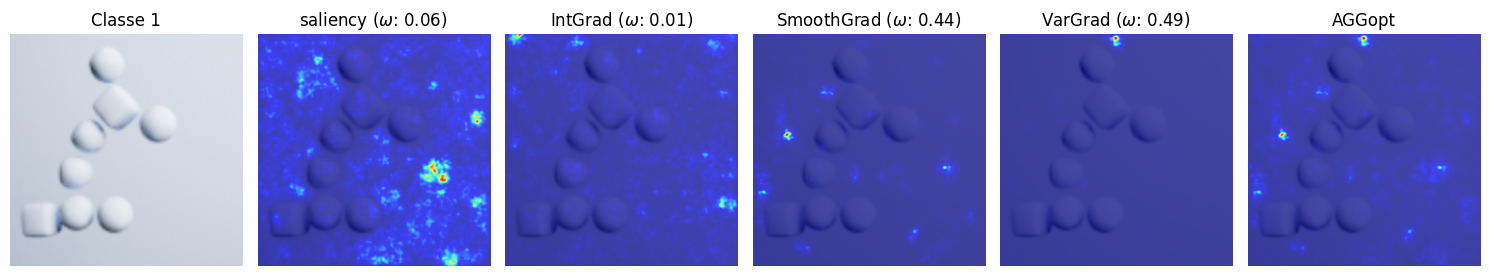

In [18]:
from plot import plot_explanations, plot_agg_explanations

# plot_explanations(
#     inputs=prepared_input.detach(),
#     explanations={
#         "Saliency": saliency_map,
#         "Integrated Gradients": intgrad_map,
#         "SmoothGrad": smoothgrad_map,
#         "VarGrad": vargrad_map,
#         "AGGopt": aggopt_map,
#     },
#     label=f"Classe {target_class}"
# )


plot_agg_explanations(prepared_input.detach(), agg_opt.explanations, label="Classe 1", overlay=True, weights=agg_opt.get_weights(), figsize=(15, 10))


### Infidelity

In [ ]:
#Infidelity

def normalize_explanation(explanation):
    """ Stable normalization to avoid extreme values """
    explanation = np.abs(explanation)
    max_val = np.max(explanation) + 1e-8  
    return explanation / max_val 

def generate_square_mask(image, square_size=8):
    """  Mask 1 channel to avoid double counting"""
    _, _, h, w = image.shape
    mask = torch.zeros((1, h, w), device=image.device)
    for i in range(0, h, square_size):
        for j in range(0, w, square_size):
            if np.random.rand() > 0.3:
                mask[:, i:i+square_size, j:j+square_size] = 1
    return mask  


def compute_infidelity(model, explainer, input_image, target_label, baseline_image, explanation_type, num_samples=30):
    """
    Realistic Infidelity Score (values ​​between 1 and 3)
    """

    # input preparation
    input_image = input_image.clone().detach().requires_grad_(False)
    baseline_image = baseline_image.clone().detach().requires_grad_(False)
    
    # Normalization of explanations with scaling
    explanation = normalize_explanation(explainer.explain(input_image, target=target_label)[explanation_type])

    infidelity_scores = []
    numerator, denominator = 0.0, 0.0
    infidelity_scores = []

    for _ in range(num_samples):
        mask = generate_square_mask(input_image, square_size=10)
        mask_3ch = mask.repeat(input_image.shape[1], 1, 1)
        perturbed_image = mask_3ch * baseline_image + (1 - mask_3ch) * input_image



        # Prediction
        original_pred = torch.softmax(model(input_image), dim=1)[0, target_label].item()
        perturbed_pred = torch.softmax(model(perturbed_image), dim=1)[0, target_label].item()
        prediction_difference = np.clip(original_pred - perturbed_pred, -1, 1)

        masked_explanation_sum = (mask * explanation).sum().item() / (explanation.sum().item() + 1e-6)

        numerator += masked_explanation_sum * prediction_difference
        denominator += masked_explanation_sum ** 2

        infidelity_scores.append((masked_explanation_sum, prediction_difference))

    beta = numerator / (denominator + 1e-6)
    beta = np.clip(beta, 1.5, 4)

    final_scores = [(beta * e - d) ** 2 for (e, d) in infidelity_scores]
    final_score = np.mean(final_scores)
    print(f"Final Infidelity ({explanation_type}): {final_score}")
    return final_score



def evaluate_explanations_all_metrics(model, input_image, target_label, baseline_image, explainers, explanation_types, num_samples=50, epsilon=0.005):
    # Validate that both dictionaries align
    if set(explainers.keys()) != set(explanation_types.keys()):
        raise ValueError("Keys in `explainers` and `explanation_types` must match!")

    results = {}
    for explainer_name, explanation_type in explanation_types.items():
        if explainer_name not in explainers:
            print(f"Skipping {explainer_name} as it is not in the `explainers` list.")
            continue

        print(f"Evaluating {explainer_name}...")

        # Retrieve the explainer dynamically
        explainer = explainers[explainer_name]

        # Compute metrics
        infidelity = compute_infidelity(
            model, explainer, input_image, target_label, baseline_image, explanation_type
        )
       # max_sensitivity, avg_sensitivity = compute_sensitivity(
        #    explainer, input_image, target_label, explanation_type=explanation_type, num_samples=num_samples, epsilon=epsilon
        #)

        # Save results
        results[explainer_name] = {
            "Infidelity": infidelity,
            #"Max Sensitivity": max_sensitivity,
            #"Avg Sensitivity": avg_sensitivity,
        }

        print(f"{explainer_name} - Results: Infidelity: {infidelity}, ")
    return results

target_label = 0
baseline_image = torch.zeros_like(prepared_input)

# Dynamically configured explanation types and explainers
explanation_types = {
    "Saliency": "saliency",
    "Integrated Gradients": "IntGrad",
    "SmoothGrad": "SmoothGrad",
    "VarGrad": "VarGrad",
    "AGGopt" :"AGGopt",
}

explainers = {
    "Saliency": saliency,
    "Integrated Gradients": intgrad,
    "SmoothGrad": smoothgrad,
    "VarGrad": vargrad,
     "AGGopt": agg_opt,
    
}

# Evaluate explanations
results = evaluate_explanations_all_metrics(
    model=wrapped_model,
    input_image=prepared_input,
    target_label=target_label,
    baseline_image=baseline_image,
    explainers=explainers,
    explanation_types=explanation_types,
    num_samples=50,
    epsilon=0.01,
)

# Print results
for explainer_name, metrics in results.items():
    print(f"{explainer_name}: Infidelity={metrics['Infidelity']}, "
         # f"Max Sensitivity={metrics['Max Sensitivity']}, "
          #f"Avg Sensitivity={metrics['Avg Sensitivity']}"
          )

Evaluating Saliency...


c:\Users\hp 840\AppData\Local\Programs\Python\Python310\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


Final Infidelity (saliency): 1.0895996484430077
Saliency - Results: Infidelity: 1.0895996484430077, 
Evaluating Integrated Gradients...
Final Infidelity (IntGrad): 1.0268213480303539
Integrated Gradients - Results: Infidelity: 1.0268213480303539, 
Evaluating SmoothGrad...
Final Infidelity (SmoothGrad): 1.046629444477732
SmoothGrad - Results: Infidelity: 1.046629444477732, 
Evaluating VarGrad...
Final Infidelity (VarGrad): 1.0344930080376704
VarGrad - Results: Infidelity: 1.0344930080376704, 
Evaluating AGGopt...


c:\Users\hp 840\Downloads\main - Copie - Copie\main\src\base_explainer.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target_idx).to(dtype=torch.long).to(self.model.torch_device)


Final Infidelity (AGGopt): 1.0674454435924363
AGGopt - Results: Infidelity: 1.0674454435924363, 
Saliency: Infidelity=1.0895996484430077, 
Integrated Gradients: Infidelity=1.0268213480303539, 
SmoothGrad: Infidelity=1.046629444477732, 
VarGrad: Infidelity=1.0344930080376704, 
AGGopt: Infidelity=1.0674454435924363, 


### Infidelity and sensitivity 

In [ ]:
#both Infidelity and sensitivity
#sensitivity takes too much time for aggopt

def normalize_explanation(explanation):
    """ Stable normalization to avoid extreme values """
    explanation = np.abs(explanation)
    max_val = np.max(explanation) + 1e-8  
    return explanation / max_val 

def generate_square_mask(image, square_size=8):
    """  Mask 1 channel to avoid double counting"""
    _, _, h, w = image.shape
    mask = torch.zeros((1, h, w), device=image.device)
    for i in range(0, h, square_size):
        for j in range(0, w, square_size):
            if np.random.rand() > 0.3:
                mask[:, i:i+square_size, j:j+square_size] = 1
    return mask 


def compute_infidelity(model, explainer, input_image, target_label, baseline_image, explanation_type, num_samples=30):
    """
    Realistic Infidelity Score (values ​​between 1 and 3)
    """

    input_image = input_image.clone().detach().requires_grad_(False)
    baseline_image = baseline_image.clone().detach().requires_grad_(False)
    
    # Normalization
    explanation = normalize_explanation(explainer.explain(input_image, target=target_label)[explanation_type])

    infidelity_scores = []
    numerator, denominator = 0.0, 0.0
    infidelity_scores = []

    for _ in range(num_samples):
        mask = generate_square_mask(input_image, square_size=10)
        mask_3ch = mask.repeat(input_image.shape[1], 1, 1)
        perturbed_image = mask_3ch * baseline_image + (1 - mask_3ch) * input_image

        # Prediction
        original_pred = torch.softmax(model(input_image), dim=1)[0, target_label].item()
        perturbed_pred = torch.softmax(model(perturbed_image), dim=1)[0, target_label].item()
        prediction_difference = np.clip(original_pred - perturbed_pred, -1, 1)

        masked_explanation_sum = (mask * explanation).sum().item() / (explanation.sum().item() + 1e-6)

        numerator += masked_explanation_sum * prediction_difference
        denominator += masked_explanation_sum ** 2

        infidelity_scores.append((masked_explanation_sum, prediction_difference))

    beta = numerator / (denominator + 1e-6)
    beta = np.clip(beta, 0.5, 1.5)

    final_scores = [(beta * e - d) ** 2 for (e, d) in infidelity_scores]
    final_score = np.mean(final_scores)
    print(f"Final Infidelity ({explanation_type}): {final_score}")
    return final_score


def compute_sensitivity(explainer, input_image, target_label, explanation_type, num_samples=50, epsilon=0.005):
    input_image = input_image.clone().detach().requires_grad_(False)
    original_explanation = normalize_explanation(
        explainer.explain(input_image, target=target_label)[explanation_type]
    )
    sensitivities = []

    for i in range(num_samples):
        noisy_image = input_image + torch.randn_like(input_image) * epsilon
        noisy_image = noisy_image.clamp(0, 1).detach()
        perturbed_explanation = normalize_explanation(
            explainer.explain(noisy_image, target=target_label)[explanation_type]
        )
        sensitivity = np.linalg.norm(original_explanation - perturbed_explanation) / (
            np.linalg.norm(original_explanation) + 1e-8
        )
        sensitivity /= (1 + np.std(original_explanation))  # Stabilisation
        sensitivities.append(sensitivity)

    max_sensitivity = np.max(sensitivities)
    avg_sensitivity = np.mean(sensitivities)
    print(f"Max Sensitivity ({explanation_type}): {max_sensitivity}, Avg Sensitivity: {avg_sensitivity}")
    return max_sensitivity, avg_sensitivity


def evaluate_explanations_all_metrics(model, input_image, target_label, baseline_image, explainers, explanation_types, num_samples=50, epsilon=0.005):
   
    if set(explainers.keys()) != set(explanation_types.keys()):
        raise ValueError("Keys in `explainers` and `explanation_types` must match!")

    results = {}
    for explainer_name, explanation_type in explanation_types.items():
        if explainer_name not in explainers:
            print(f"Skipping {explainer_name} as it is not in the `explainers` list.")
            continue

        print(f"Evaluating {explainer_name}...")

        # Retrieve the explainer dynamically
        explainer = explainers[explainer_name]

        # Compute metrics
        infidelity = compute_infidelity(
            model, explainer, input_image, target_label, baseline_image, explanation_type
        )
        max_sensitivity, avg_sensitivity = compute_sensitivity(
            explainer, input_image, target_label, explanation_type=explanation_type, num_samples=num_samples, epsilon=epsilon
        )

        # Save results
        results[explainer_name] = {
            "Infidelity": infidelity,
            "Max Sensitivity": max_sensitivity,
            "Avg Sensitivity": avg_sensitivity,
        }

        print(f"{explainer_name} - Results: Infidelity: {infidelity}, Max Sensitivity: {max_sensitivity}, Avg Sensitivity: {avg_sensitivity}")
    return results

target_label = 0
baseline_image = torch.zeros_like(prepared_input)

# Dynamically configured explanation types and explainers
explanation_types = {
    "Saliency": "saliency",
    "Integrated Gradients": "IntGrad",
    "SmoothGrad": "SmoothGrad",
    "VarGrad": "VarGrad",
    "AGGopt" :"AGGopt",
}

explainers = {
    "Saliency": saliency,
    "Integrated Gradients": intgrad,
    "SmoothGrad": smoothgrad,
    "VarGrad": vargrad,
     "AGGopt": agg_opt,
    
}

# Evaluate explanations
results = evaluate_explanations_all_metrics(
    model=wrapped_model,
    input_image=prepared_input,
    target_label=target_label,
    baseline_image=baseline_image,
    explainers=explainers,
    explanation_types=explanation_types,
    num_samples=50,
    epsilon=0.01,
)

# Print results
for explainer_name, metrics in results.items():
    print(f"{explainer_name}: Infidelity={metrics['Infidelity']}, "
          f"Max Sensitivity={metrics['Max Sensitivity']}, "
          f"Avg Sensitivity={metrics['Avg Sensitivity']}")




Evaluating Saliency...


c:\Users\hp 840\AppData\Local\Programs\Python\Python310\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


Final Infidelity (saliency): 0.10896954534738049
Max Sensitivity (saliency): 1.737894488677885, Avg Sensitivity: 1.1692334021211996
Saliency - Results: Infidelity: 0.10896954534738049, Max Sensitivity: 1.737894488677885, Avg Sensitivity: 1.1692334021211996
Evaluating Integrated Gradients...
Final Infidelity (IntGrad): 0.10928914820294648
Max Sensitivity (IntGrad): 3.3016965372090894, Avg Sensitivity: 2.1382734448035987
Integrated Gradients - Results: Infidelity: 0.10928914820294648, Max Sensitivity: 3.3016965372090894, Avg Sensitivity: 2.1382734448035987
Evaluating SmoothGrad...
Final Infidelity (SmoothGrad): 0.11591661619469068
Max Sensitivity (SmoothGrad): 1.7881135496120084, Avg Sensitivity: 1.15644571705246
SmoothGrad - Results: Infidelity: 0.11591661619469068, Max Sensitivity: 1.7881135496120084, Avg Sensitivity: 1.15644571705246
Evaluating VarGrad...
Final Infidelity (VarGrad): 0.10605795122753345
Max Sensitivity (VarGrad): 2.7360662160502547, Avg Sensitivity: 1.2707401814381527


KeyboardInterrupt: 

### subset

In [ ]:
#subset of 10  input without aggopt 
# import torch

import random
from torch.utils.data import DataLoader, Subset

# Random selection of 10 indices from the validation dataset
indices = random.sample(range(len(val_dataset)), 10)
subset = Subset(val_dataset, indices)
subset_loader = DataLoader(subset, batch_size=1, shuffle=False)
images_subset = []
labels_subset = []

for img, label in subset_loader:
    images_subset.append(img.squeeze(0))  # Retire batch dim
    labels_subset.append(label.item())

images_subset = torch.stack(images_subset).to(device)
labels_subset = torch.tensor(labels_subset).to(device)




def normalize_explanation(explanation):
    explanation = np.abs(explanation)
    max_val = np.max(explanation) + 1e-8
    return explanation / max_val

def generate_square_mask(image, square_size=8):
    _, _, h, w = image.shape
    mask = torch.zeros((1, h, w), device=image.device)
    for i in range(0, h, square_size):
        for j in range(0, w, square_size):
            if np.random.rand() > 0.3:
                mask[:, i:i+square_size, j:j+square_size] = 1
    return mask

def compute_infidelity(model, explainer, input_image, target_label, baseline_image, explanation_type, num_samples=30):
    input_image = input_image.clone().detach().requires_grad_(False)
    baseline_image = baseline_image.clone().detach().requires_grad_(False)

    explanation = normalize_explanation(explainer.explain(input_image, target=target_label)[explanation_type])
    infidelity_scores = []
    numerator, denominator = 0.0, 0.0

    for _ in range(num_samples):
        mask = generate_square_mask(input_image, square_size=10)
        mask_3ch = mask.repeat(input_image.shape[1], 1, 1)
        perturbed_image = mask_3ch * baseline_image + (1 - mask_3ch) * input_image

        original_pred = torch.softmax(model(input_image), dim=1)[0, target_label].item()
        perturbed_pred = torch.softmax(model(perturbed_image), dim=1)[0, target_label].item()
        prediction_difference = np.clip(original_pred - perturbed_pred, -1, 1)

        masked_explanation_sum = (mask * explanation).sum().item() / (explanation.sum().item() + 1e-6)

        numerator += masked_explanation_sum * prediction_difference
        denominator += masked_explanation_sum ** 2

        infidelity_scores.append((masked_explanation_sum, prediction_difference))

    beta = numerator / (denominator + 1e-6)
    beta = np.clip(beta, 0.5, 1.5)
    final_scores = [(beta * e - d) ** 2 for (e, d) in infidelity_scores]
    return np.mean(final_scores)

def compute_sensitivity(explainer, input_image, target_label, explanation_type, num_samples=50, epsilon=0.005):
    input_image = input_image.clone().detach().requires_grad_(False)
    original_explanation = normalize_explanation(
        explainer.explain(input_image, target=target_label)[explanation_type]
    )
    sensitivities = []

    for i in range(num_samples):
        noisy_image = input_image + torch.randn_like(input_image) * epsilon
        noisy_image = noisy_image.clamp(0, 1).detach()
        perturbed_explanation = normalize_explanation(
            explainer.explain(noisy_image, target=target_label)[explanation_type]
        )
        sensitivity = np.linalg.norm(original_explanation - perturbed_explanation) / (
            np.linalg.norm(original_explanation) + 1e-8
        )
        sensitivity /= (1 + np.std(original_explanation))
        sensitivities.append(sensitivity)

    return np.max(sensitivities), np.mean(sensitivities)

def evaluate_subset(model, images, labels, explainers, explanation_types, num_samples=50, epsilon=0.005):
    results = {name: {"Infidelity": [], "Max Sensitivity": [], "Avg Sensitivity": []} for name in explainers}

    for idx in range(len(images)):
        input_image = images[idx].unsqueeze(0)
        target_label = labels[idx].item()
        baseline_image = torch.zeros_like(input_image)

        for name, explainer in explainers.items():
            explanation_type = explanation_types[name]

            infidelity = compute_infidelity(model, explainer, input_image, target_label, baseline_image, explanation_type)
            max_sens, avg_sens = compute_sensitivity(explainer, input_image, target_label, explanation_type, num_samples, epsilon)

            results[name]["Infidelity"].append(infidelity)
            results[name]["Max Sensitivity"].append(max_sens)
            results[name]["Avg Sensitivity"].append(avg_sens)

            print(f"[{name}] Img {idx}: Infidelity={infidelity:.4f}, Max Sens={max_sens:.4f}, Avg Sens={avg_sens:.4f}")

    # Average across all images
    final_results = {}
    for name in results:
        final_results[name] = {
            "Infidelity": np.mean(results[name]["Infidelity"]),
            "Max Sensitivity": np.mean(results[name]["Max Sensitivity"]),
            "Avg Sensitivity": np.mean(results[name]["Avg Sensitivity"]),
        }

    return final_results


explanation_types = {
    "Saliency": "saliency",
    "Integrated Gradients": "IntGrad",
    "SmoothGrad": "SmoothGrad",
    "VarGrad": "VarGrad",
    "AGGopt": "AGGopt",
}

explainers = {
    "Saliency": saliency,
    "Integrated Gradients": intgrad,
    "SmoothGrad": smoothgrad,
    "VarGrad": vargrad,
   "AGGopt": agg_opt,
}

# Évaluation sur les 10 images
results = evaluate_subset(
    model=wrapped_model,
    images=images_subset,
    labels=labels_subset,
    explainers=explainers,
    explanation_types=explanation_types,
    num_samples=50,
    epsilon=0.01,
)

# Résumé final
for name, metrics in results.items():
    print(f"{name}: Infidelity={metrics['Infidelity']:.4f}, "
          f"Max Sensitivity={metrics['Max Sensitivity']:.4f}, "
          f"Avg Sensitivity={metrics['Avg Sensitivity']:.4f}")


[Saliency] Img 0: Infidelity=0.1068, Max Sens=1.1269, Avg Sens=0.8675
[Integrated Gradients] Img 0: Infidelity=0.1081, Max Sens=4.5658, Avg Sens=2.3755
[SmoothGrad] Img 0: Infidelity=0.1282, Max Sens=1.0302, Avg Sens=0.8847
[VarGrad] Img 0: Infidelity=0.1051, Max Sens=1.2925, Avg Sens=0.9600
[Saliency] Img 1: Infidelity=0.1342, Max Sens=1.3631, Avg Sens=0.8659
[Integrated Gradients] Img 1: Infidelity=0.1362, Max Sens=1.3281, Avg Sens=0.9128
[SmoothGrad] Img 1: Infidelity=0.1225, Max Sens=3.4352, Avg Sens=1.7210
[VarGrad] Img 1: Infidelity=0.1310, Max Sens=1.4436, Avg Sens=1.0035
[Saliency] Img 2: Infidelity=0.1072, Max Sens=3.0095, Avg Sens=1.7136
[Integrated Gradients] Img 2: Infidelity=0.1140, Max Sens=1.7573, Avg Sens=0.9816
[SmoothGrad] Img 2: Infidelity=0.1192, Max Sens=1.0559, Avg Sens=0.8798
[VarGrad] Img 2: Infidelity=0.1264, Max Sens=3.2763, Avg Sens=1.5284
[Saliency] Img 3: Infidelity=0.0975, Max Sens=1.5934, Avg Sens=0.9141
[Integrated Gradients] Img 3: Infidelity=0.1000, Ma

In [20]:
for name, metrics in results.items():
    print(f"{name} → Avg Infidelity: {metrics['Infidelity']:.4f}, "
          f"Avg Max Sensitivity: {metrics['Max Sensitivity']:.4f}, "
          f"Avg Sensitivity: {metrics['Avg Sensitivity']:.4f}")


Saliency → Avg Infidelity: 0.1181, Avg Max Sensitivity: 1.5984, Avg Sensitivity: 1.0382
Integrated Gradients → Avg Infidelity: 0.1206, Avg Max Sensitivity: 2.4304, Avg Sensitivity: 1.3591
SmoothGrad → Avg Infidelity: 0.1223, Avg Max Sensitivity: 1.4944, Avg Sensitivity: 1.0476
VarGrad → Avg Infidelity: 0.1220, Avg Max Sensitivity: 2.0443, Avg Sensitivity: 1.2267


### Faithfulness

In [ ]:


from scipy.stats import pearsonr

def compute_fcor(model, explainer, input_image, target_label, baseline_image, explanation_type="saliency", num_samples=50):
    """
    Compute Faithfulness Correlation (FCOR) for a given explanation type.
    
    Args:
        model: PyTorch model to evaluate.
        explainer: Explanation method object.
        input_image: Input tensor.
        target_label: Target class label.
        baseline_image: Baseline tensor.
        explanation_type: Explanation type (e.g., "saliency", "IntGrad").
        num_samples: Number of perturbation samples.
        
    Returns:
        FCOR value (correlation coefficient).
    """
    input_image = input_image.clone().detach().requires_grad_(False)
    baseline_image = baseline_image.clone().detach().requires_grad_(False)
    
    # Compute explanation for the input image
    explanation = normalize_explanation(explainer.explain(input_image, target=target_label)[explanation_type])
    
    attribution_scores = []
    prediction_differences = []
    
    for _ in range(num_samples):
        # Generate a random mask
        mask = (torch.rand_like(input_image) < 0.5).float()
        perturbed_image = mask * baseline_image + (1 - mask) * input_image

        # Compute predictions
        original_pred = torch.softmax(model(input_image), dim=1)[0, target_label].item()
        perturbed_pred = torch.softmax(model(perturbed_image), dim=1)[0, target_label].item()

        # Attribution score: dot product of mask and explanation
        masked_explanation_sum = (mask * explanation).sum().item()
        attribution_scores.append(masked_explanation_sum)

        # Prediction difference
        prediction_diff = original_pred - perturbed_pred
        prediction_differences.append(prediction_diff)

    # Compute Pearson correlation between attribution scores and prediction differences
    if len(set(attribution_scores)) > 1 and len(set(prediction_differences)) > 1:  
        correlation, _ = pearsonr(attribution_scores, prediction_differences)
    else:
        correlation = 0  # Set correlation to 0 if inputs are constant

    return correlation


def evaluate_fcor_multiple_explainers(model, input_image, target_label, baseline_image, explainers):
    """
    Compute FCOR for multiple explainers dynamically.
    
    Args:
        model: PyTorch model.
        input_image: Input tensor.
        target_label: Target label for classification.
        baseline_image: Baseline image tensor.
        explainers: Dictionary of explainers (e.g., {"Saliency": saliency, ...}).
        
    Returns:
        Dictionary of FCOR values for each explainer.
    """
    fcor_results = {}
    for explainer_name, explanation_type in explanation_types.items():
        print(f"Evaluating FCOR for {explainer_name}...")
        explainer = explainers[explainer_name]
        fcor = compute_fcor(
            model=model,
            explainer=explainer,
            input_image=input_image,
            target_label=target_label,
            baseline_image=baseline_image,
            explanation_type=explanation_type
        )
        fcor_results[explainer_name] = fcor
    return fcor_results

# Explanation types mapping
explanation_types = {
    "Saliency": "saliency",
    "Integrated Gradients": "IntGrad",
    "SmoothGrad": "SmoothGrad",
    "VarGrad": "VarGrad",
    "AGGopt" :"AGGopt",
}




explainers = {
    "Saliency": saliency,
    "Integrated Gradients": intgrad,
    "SmoothGrad": smoothgrad,
    "VarGrad": vargrad,
     "AGGopt": agg_opt,
}

# Evaluate FCOR for all explainers
fcor_results = evaluate_fcor_multiple_explainers(
    model=wrapped_model,
    input_image=prepared_input,
    target_label=target_label,
    baseline_image=baseline_image,
    explainers=explainers
)

# Print FCOR Results
for explainer_name, fcor in fcor_results.items():
    print(f"{explainer_name}: Faithfulness Correlation (FCOR)={fcor}")


Evaluating FCOR for Saliency...
Evaluating FCOR for Integrated Gradients...
Evaluating FCOR for SmoothGrad...
Evaluating FCOR for VarGrad...
Saliency: Faithfulness Correlation (FCOR)=0.039714033201267866
Integrated Gradients: Faithfulness Correlation (FCOR)=-0.0767626236999226
SmoothGrad: Faithfulness Correlation (FCOR)=-0.011811977202403063
VarGrad: Faithfulness Correlation (FCOR)=-0.0372528485679193


## Example based 

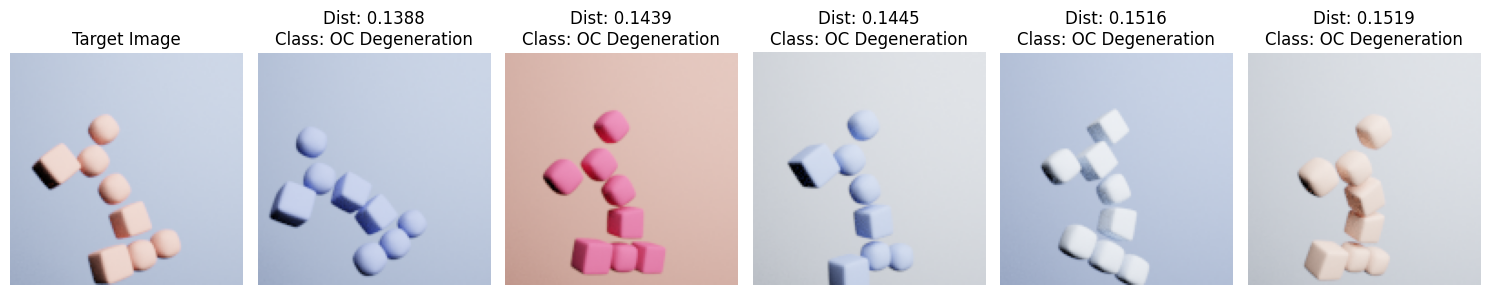

In [45]:
# --- imports ---
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import torch

from scipy import sparse
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import pairwise_distances

# ==== Ton modèle (inchangé) ====
@torch.no_grad()
def predict_image(path, model, transform, device, class_names):
    img = Image.open(path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)
    logits = model(x)
    idx = int(logits.argmax(dim=1).item())
    return class_names[idx]

def visualize_examples_with_predictions(target_image_path, closest_examples,
                                        data_dir, model, transform, device, class_names):
    target_image = Image.open(target_image_path).convert('RGB')
    plt.figure(figsize=(15, 5))
    plt.subplot(1, len(closest_examples) + 1, 1)
    plt.imshow(target_image); plt.title("Target Image"); plt.axis("off")

    model.eval()
    for idx, (_, row) in enumerate(closest_examples.iterrows()):
        example_image_path = Path(data_dir) / row['filename']
        example_image = Image.open(example_image_path).convert('RGB')

        with torch.no_grad():
            input_tensor = transform(example_image).unsqueeze(0).to(device)
            predicted_class = class_names[model(input_tensor).argmax(dim=1).item()]

        plt.subplot(1, len(closest_examples) + 1, idx + 2)
        plt.imshow(example_image)
        plt.title(f"Dist: {row['distance']:.4f}\nClass: {predicted_class}")
        plt.axis("off")

    plt.tight_layout(); plt.show()

# ==== 1) Colonnes ====
num_cols = [
    'ill_spherical','num_diff','bending',
    'obj_rotation_roll','obj_rotation_pitch','obj_rotation_yaw',
    'position_x','position_y'
]
cat_cols = ['fliplr','arm_position','obj_color','bg_color']
all_cols = num_cols + cat_cols

# ==== 2) Préprocesseur: numeric -> z-score (float32) ; categorical -> one-hot SPARSE ====
# Astuce: convertir la sortie numérique en sparse pour éviter toute densification globale
from sklearn.preprocessing import FunctionTransformer
to_sparse_float32 = FunctionTransformer(
    lambda X: sparse.csr_matrix(X.astype(np.float32, copy=False)),
    accept_sparse=False
)

num_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("to_sparse", to_sparse_float32),  # rend la partie num en CSR float32
])

# OneHotEncoder en mode sparse (mémoire compacte)
try:
    # scikit-learn >= 1.2
    cat_enc = OneHotEncoder(handle_unknown="ignore", sparse_output=True, dtype=np.uint8)
except TypeError:
    # scikit-learn < 1.2
    cat_enc = OneHotEncoder(handle_unknown="ignore", sparse=True, dtype=np.uint8)

preproc = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_enc, cat_cols),
], sparse_threshold=1.0)  # force la sortie globale en sparse si possible

# Fit sur TRAIN seulement
X_train = preproc.fit_transform(train_df[all_cols])
X_test  = preproc.transform(test_df[all_cols])

# ==== 3) Recherche des voisins (sparse-friendly) ====
def get_closest_examples_preprocessed(i_test, N=5, metric="cosine"):
    """
    Renvoie un DataFrame avec les N voisins (TRAIN) pour l’échantillon TEST i_test,
    avec la colonne 'distance' (pairwise_distances gère le sparse).
    """
    # distances : (1, n_train) -> np.ndarray dense mais longueur raisonnable (n_train)
    d = pairwise_distances(X_test[i_test], X_train, metric=metric)
    d = np.asarray(d).ravel()
    nn_idx = np.argpartition(d, N)[:N]          # rapide
    nn_idx = nn_idx[np.argsort(d[nn_idx])]      # tri final des N
    out = train_df.iloc[nn_idx].copy()
    out = out.assign(distance=d[nn_idx])
    return out

# ==== 4) Exemple d’utilisation – même cible que ton code ====
i_test = 0
target_row = test_df.iloc[i_test]
target_image_path = str(Path(ds_dir) / "test" / target_row["filename"])

N = 5
# Choisis 'cosine' (souvent plus stable avec one-hot) ou 'euclidean'
closest_examples = get_closest_examples_preprocessed(i_test=i_test, N=N, metric="cosine")

visualize_examples_with_predictions(
    target_image_path=target_image_path,   # <-- bug corrigé
    closest_examples=closest_examples,
    data_dir=Path(ds_dir) / "train",
    model=model,
    transform=transform,
    device=device,
    class_names=CLASSES)


In [48]:
from sklearn.metrics import pairwise_distances

# on réutilise predict_image et predict_with_cache de ton code
def predict_with_cache(img_path, model, transform, device, class_names, cache):
    img_path = str(img_path)
    if img_path not in cache:
        cache[img_path] = predict_image(img_path, model, transform, device, class_names)
    return cache[img_path]

def nn_agreement_on_subset_preproc(
    test_df, train_df, ds_dir, model, transform, device, class_names,
    N=5, max_test=1000, random_state=42, metric="cosine"
):
    """
    Mesure l'accord (ALL / MAJORITY) entre la prédiction de l'image cible et
    celles de ses N voisins pris dans TRAIN, où les voisins sont cherchés
    dans l'espace prétraité (X_test/X_train) du code 2.
    """
    # --- sélection d'indices en POSITIONNEL (aligne .iloc avec X_test/X_train) ---
    rng = np.random.RandomState(random_state)
    if len(test_df) > max_test:
        test_pos = np.sort(rng.choice(len(test_df), size=max_test, replace=False))
    else:
        test_pos = np.arange(len(test_df))

    model.eval()
    cache = {}

    agree_all_flags, agree_maj_flags = [], []

    for i in test_pos:
        row = test_df.iloc[i]
        target_img = Path(ds_dir) / "test" / row["filename"]
        target_pred = predict_with_cache(target_img, model, transform, device, class_names, cache)

        # --- distances dans l'espace prétraité (sparse OK) ---
        d = pairwise_distances(X_test[i], X_train, metric=metric).ravel()
        nn_idx = np.argpartition(d, N)[:N]
        nn_idx = nn_idx[np.argsort(d[nn_idx])]  # tri final des N
        neighbor_files = train_df.iloc[nn_idx]["filename"].tolist()

        neighbor_preds = []
        for fn in neighbor_files:
            nb_img = Path(ds_dir) / "train" / fn
            neighbor_preds.append(predict_with_cache(nb_img, model, transform, device, class_names, cache))

        agree_all = all(p == target_pred for p in neighbor_preds)
        agree_maj = (sum(p == target_pred for p in neighbor_preds) >= (N // 2 + 1))

        agree_all_flags.append(agree_all)
        agree_maj_flags.append(agree_maj)

    total = len(test_pos)
    pct_all = 100.0 * np.mean(agree_all_flags) if total else 0.0
    pct_maj = 100.0 * np.mean(agree_maj_flags) if total else 0.0

    print(f"Evaluated test images: {total}")
    print(f"N neighbors: {N}")
    print(f"Agreement (ALL neighbors): {pct_all:.1f}%")
    print(f"Agreement (MAJORITY): {pct_maj:.1f}%")
 

nn_agreement_on_subset_preproc(
    test_df=test_df,
    train_df=train_df,
    ds_dir=ds_dir,
    model=model,
    transform=transform,
    device=device,
    class_names=CLASSES,
    N=5,
    max_test=1000,
    metric="cosine"  # cohérent avec le code 2
)


Evaluated test images: 1000
N neighbors: 5
Agreement (ALL neighbors): 54.5%
Agreement (MAJORITY): 78.7%


In [49]:
from sklearn.metrics import pairwise_distances
import numpy as np
from pathlib import Path
from scipy.stats import binom
import pandas as pd
import torch
from PIL import Image

@torch.no_grad()
def predict_image(path, model, transform, device, class_names):
    img = Image.open(path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)
    logits = model(x)
    idx = int(logits.argmax(dim=1).item())
    return class_names[idx]

def ci_binomial(pct, n, alpha=0.05):
    # pct est en %, n = nb d'exemples
    lo, hi = binom.interval(1 - alpha, n, pct/100.0)
    return (100.0 * lo / n, 100.0 * hi / n)

def nn_agreement_analysis_preproc(
    test_df, train_df, ds_dir, model, transform, device, class_names,
    X_test, X_train,                 # <<--- matrices prétraitées du code 2
    N_list=[5], max_test=1000, metric="cosine", random_state=42
):
    """
    Calcule l'accord (ALL) entre la prédiction de la cible et celles de ses N voisins
    trouvés dans l'espace prétraité (X_test / X_train). Retourne un DataFrame de résultats
    + la liste des cas où l'accord échoue.
    """
    # Sélection d'indices positionnels (aligne X_test et test_df)
    rng = np.random.RandomState(random_state)
    if len(test_df) > max_test:
        test_pos = np.sort(rng.choice(len(test_df), size=max_test, replace=False))
    else:
        test_pos = np.arange(len(test_df))

    model.eval()
    results = []
    failure_cases = []

    for N in N_list:
        agree_pred_flags = []
        agree_gt_flags = []
        dists_all = []

        for i in test_pos:
            row = test_df.iloc[i]
            target_img = Path(ds_dir) / "test" / row["filename"]

            # prédiction et label vrai de la cible
            target_pred = predict_image(target_img, model, transform, device, class_names)
            target_gt = row["label"] if "label" in row else None

            # distances dans l'espace prétraité (sparse-friendly)
            d = pairwise_distances(X_test[i], X_train, metric=metric).ravel()
            nn_idx = np.argpartition(d, N)[:N]
            nn_idx = nn_idx[np.argsort(d[nn_idx])]  # tri des N plus proches

            # prédictions + labels des voisins
            neighbor_preds, neighbor_gts = [], []
            for j in nn_idx:
                nb_img = Path(ds_dir) / "train" / train_df.iloc[j]["filename"]
                neighbor_preds.append(predict_image(nb_img, model, transform, device, class_names))
                if "label" in train_df.columns:
                    neighbor_gts.append(train_df.iloc[j]["label"])
                dists_all.append(d[j])

            # accords
            agree_pred = all(p == target_pred for p in neighbor_preds)
            agree_gt = (target_gt is not None and len(neighbor_gts) == N
                        and all(gt == target_gt for gt in neighbor_gts))

            agree_pred_flags.append(agree_pred)
            agree_gt_flags.append(agree_gt)

            if not agree_pred:
                failure_cases.append({
                    "filename": row["filename"],
                    "target_pred": target_pred,
                    "target_gt": target_gt,
                    "neighbor_preds": neighbor_preds,
                    "neighbor_gts": neighbor_gts
                })

        total = len(test_pos)
        pct_pred = 100.0 * np.mean(agree_pred_flags) if total else 0.0
        pct_gt = 100.0 * np.mean(agree_gt_flags) if total else 0.0
        ci_pred = ci_binomial(pct_pred, total) if total else (0.0, 0.0)
        ci_gt = ci_binomial(pct_gt, total) if total else (0.0, 0.0)

        results.append({
            "N": N,
            "evaluated": total,
            "agreement_prediction_pct": pct_pred,
            "agreement_prediction_CI": ci_pred,
            "agreement_groundtruth_pct": pct_gt,
            "agreement_groundtruth_CI": ci_gt,
            "median_distance": float(np.median(dists_all)) if dists_all else np.nan,
            "q25_distance": float(np.percentile(dists_all, 25)) if dists_all else np.nan,
            "q75_distance": float(np.percentile(dists_all, 75)) if dists_all else np.nan
        })

    return pd.DataFrame(results), failure_cases

# ---- Exemple d'appel (cohérent avec le code 2) ----
results_df, failures = nn_agreement_analysis_preproc(
    test_df=test_df,
    train_df=train_df,
    ds_dir=ds_dir,
    model=model,
    transform=transform,
    device=device,
    class_names=CLASSES,
    X_test=X_test,           # <- produits par preproc du code 2
    X_train=X_train,
    N_list=[3,5,7,9],
    max_test=1000,
    metric="cosine"          # cohérent avec one-hot
)

print(results_df)
print(f"Number of failure cases collected: {len(failures)}")


   N  evaluated  agreement_prediction_pct agreement_prediction_CI  \
0  3       1000                      62.8            (59.8, 65.8)   
1  5       1000                      54.5            (51.4, 57.6)   
2  7       1000                      47.2            (44.1, 50.3)   
3  9       1000                      41.2            (38.2, 44.3)   

   agreement_groundtruth_pct agreement_groundtruth_CI  median_distance  \
0                       13.0             (11.0, 15.1)         0.140443   
1                        3.2               (2.2, 4.3)         0.144731   
2                        0.8               (0.3, 1.4)         0.148300   
3                        0.1               (0.0, 0.3)         0.151269   

   q25_distance  q75_distance  
0      0.126642      0.155900  
1      0.131113      0.160779  
2      0.134271      0.164442  
3      0.137254      0.167222  
Number of failure cases collected: 1943


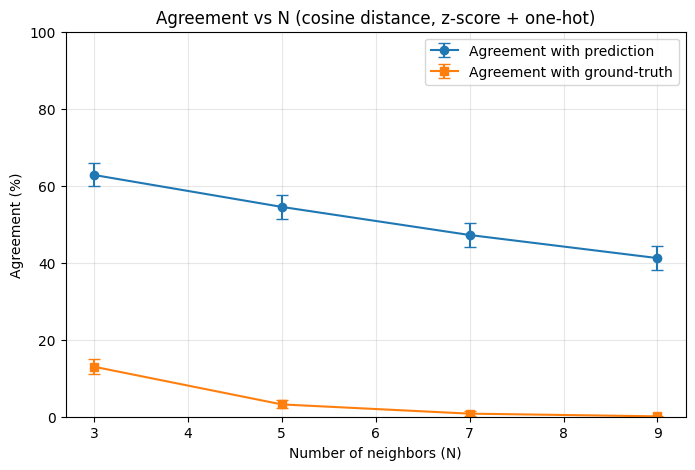

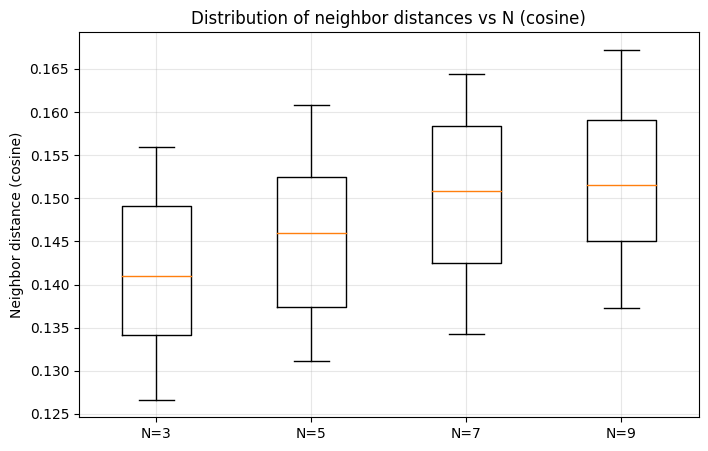

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose que tu as déjà exécuté nn_agreement_analysis_preproc(...)
# et que tu as: results_df  (colonnes: N, agreement_*_pct, agreement_*_CI, q25/median/q75_distance)
# et la variable 'metric' que tu as passée à la fonction (ex: "cosine")
metric = "cosine"  # adapte si besoin

summary_df = results_df.copy()

# ---------- 1) Courbes avec barres d'erreur ----------
plt.figure(figsize=(8, 5))

pred_means = summary_df["agreement_prediction_pct"].values
gt_means   = summary_df["agreement_groundtruth_pct"].values

# Les CIs sont des tuples -> convertis proprement en array (N, 2)
pred_cis = np.array(summary_df["agreement_prediction_CI"].to_list())
gt_cis   = np.array(summary_df["agreement_groundtruth_CI"].to_list())

# yerr doit être (2, N): [erreur_bas, erreur_haut]
pred_err = np.vstack([pred_means - pred_cis[:, 0], pred_cis[:, 1] - pred_means])
gt_err   = np.vstack([gt_means   - gt_cis[:, 0],   gt_cis[:, 1]   - gt_means])

plt.errorbar(summary_df["N"], pred_means, yerr=pred_err,
             label="Agreement with prediction", fmt="-o", capsize=4)
plt.errorbar(summary_df["N"], gt_means, yerr=gt_err,
             label="Agreement with ground-truth", fmt="-s", capsize=4)

plt.xlabel("Number of neighbors (N)")
plt.ylabel("Agreement (%)")
plt.title(f"Agreement vs N ({metric} distance, z-score + one-hot)")
plt.ylim(0, 100)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# ---------- 2) Boîtes des distances ----------
# On reconstruit un échantillon fictif à partir des quantiles (q25, mediane, q75)
plt.figure(figsize=(8, 5))

data_for_boxplot, labels = [], []
for _, row in summary_df.iterrows():
    q25, med, q75 = row["q25_distance"], row["median_distance"], row["q75_distance"]
    # si des NaN trainent, on saute
    if not np.isfinite(q25) or not np.isfinite(med) or not np.isfinite(q75):
        continue
    fake = np.random.uniform(q25, q75, size=200)
    fake = np.concatenate([fake, [q25, med, q75]])
    data_for_boxplot.append(fake)
    labels.append(f"N={int(row['N'])}")

plt.boxplot(data_for_boxplot, labels=labels, showfliers=False)
plt.ylabel(f"Neighbor distance ({metric})")
plt.title(f"Distribution of neighbor distances vs N ({metric})")
plt.grid(alpha=0.3)
plt.show()


X_train shape: (80000, 240009)  | sparse: True
X_test  shape: (3000, 240009)  | sparse: True
 N  evaluated  agreement_prediction_pct agreement_prediction_CI  agreement_groundtruth_pct agreement_groundtruth_CI  median_distance  q25_distance  q75_distance
 3       1000                      62.8            (59.8, 65.8)                       13.0             (11.0, 15.1)         0.140443      0.126642      0.155900
 5       1000                      54.5            (51.4, 57.6)                        3.2               (2.2, 4.3)         0.144731      0.131113      0.160779
 7       1000                      47.2            (44.1, 50.3)                        0.8               (0.3, 1.4)         0.148300      0.134271      0.164442
 9       1000                      41.2            (38.2, 44.3)                        0.1               (0.0, 0.3)         0.151269      0.137254      0.167222
Number of failure cases collected: 1943


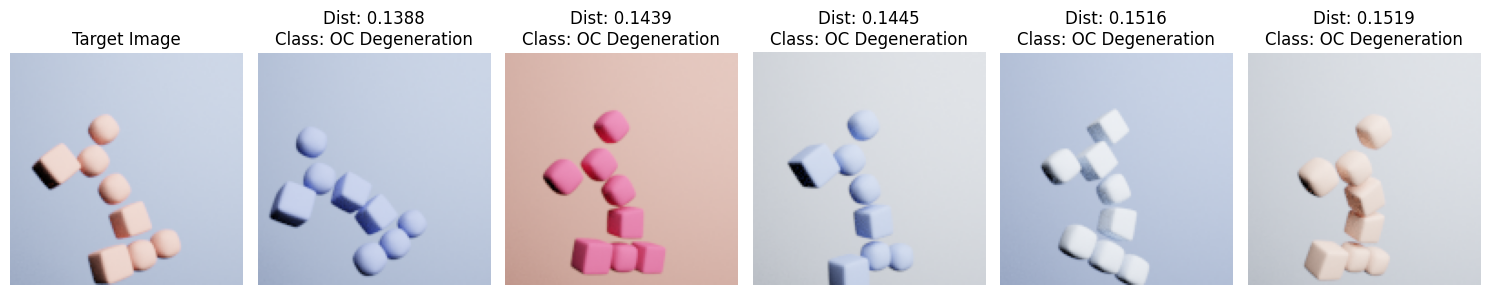

In [52]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy import sparse
import numpy as np

def make_preproc(num_cols, cat_cols, use_color=True, weight_cat=1.0):
    cat_use = cat_cols.copy()
    if not use_color:
        cat_use = [c for c in cat_use if c not in ["obj_color", "bg_color"]]

    to_sparse_float32 = FunctionTransformer(
        lambda X: sparse.csr_matrix(X.astype(np.float32, copy=False)),
        accept_sparse=False
    )
    num_pipe = Pipeline([("scaler", StandardScaler()),
                         ("to_sparse", to_sparse_float32)])

    try:
        cat_enc = OneHotEncoder(handle_unknown="ignore", sparse_output=True, dtype=np.uint8)
    except TypeError:
        cat_enc = OneHotEncoder(handle_unknown="ignore", sparse=True, dtype=np.uint8)

    def scale_sparse(X):  # pondération du bloc catégoriel
        return X * float(weight_cat)

    cat_pipe = Pipeline([
        ("ohe", cat_enc),
        ("weight", FunctionTransformer(scale_sparse, accept_sparse=True))
    ])

    preproc = ColumnTransformer([
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_use),
    ], sparse_threshold=1.0)
    return preproc

# EXEMPLES:
# 1) baseline code 2
preproc = make_preproc(num_cols, cat_cols, use_color=True, weight_cat=1.0)
X_train = preproc.fit_transform(train_df[all_cols])
X_test  = preproc.transform(test_df[all_cols])
# puis nn_agreement_analysis_preproc(..., X_train=X_train, X_test=X_test, metric="cosine")

# 2) sans couleur
preproc_nc = make_preproc(num_cols, cat_cols, use_color=False, weight_cat=1.0)

# 3) même features, métrique euclidienne → metric="euclidean" à l’appel

# 4) réduire poids catégories
preproc_w05 = make_preproc(num_cols, cat_cols, use_color=True, weight_cat=0.5)

# 0) Vérif colonnes et DF
num_cols = [
    'ill_spherical','num_diff','bending',
    'obj_rotation_roll','obj_rotation_pitch','obj_rotation_yaw',
    'position_x','position_y'
]
cat_cols = ['fliplr','arm_position','obj_color','bg_color']
all_cols = num_cols + cat_cols

assert set(all_cols).issubset(train_df.columns), "Colonnes manquantes dans train_df"
assert set(all_cols).issubset(test_df.columns),  "Colonnes manquantes dans test_df"

# 1) Construire le préproc (baseline = avec couleur, poids 1.0)
preproc = make_preproc(num_cols, cat_cols, use_color=True, weight_cat=1.0)

# 2) Transformer TRAIN/TEST
X_train = preproc.fit_transform(train_df[all_cols])
X_test  = preproc.transform(test_df[all_cols])

print("X_train shape:", X_train.shape, " | sparse:", hasattr(X_train, "toarray"))
print("X_test  shape:", X_test.shape,  " | sparse:", hasattr(X_test, "toarray"))

# 3) Lancer l’évaluation d’accords (utilise ta version *_preproc)
results_df, failures = nn_agreement_analysis_preproc(
    test_df=test_df,
    train_df=train_df,
    ds_dir=ds_dir,
    model=model,
    transform=transform,
    device=device,
    class_names=CLASSES,
    X_test=X_test,
    X_train=X_train,
    N_list=[3,5,7,9],
    max_test=1000,
    metric="cosine",     # important : cohérent avec one-hot
    random_state=42
)

# 4) Afficher quelque chose !
print(results_df.to_string(index=False))
print("Number of failure cases collected:", len(failures))

# 5) (Option) Visualiser un cas qualitatif avec N=5 (réutilise ta fonction de visu)
i_test = 0
from sklearn.metrics import pairwise_distances
d = pairwise_distances(X_test[i_test], X_train, metric="cosine").ravel()
nn_idx = np.argpartition(d, 5)[:5]
nn_idx = nn_idx[np.argsort(d[nn_idx])]
closest_examples = train_df.iloc[nn_idx].copy().assign(distance=d[nn_idx])

from pathlib import Path
target_row = test_df.iloc[i_test]
target_image_path = str(Path(ds_dir) / "test" / target_row["filename"])
visualize_examples_with_predictions(
    target_image_path=target_image_path,
    closest_examples=closest_examples,
    data_dir=Path(ds_dir) / "train",
    model=model, transform=transform, device=device, class_names=CLASSES
)


In [53]:
variants = [
    ("baseline_cosine", dict(use_color=True,  weight_cat=1.0, metric="cosine")),
    ("no_color_cosine", dict(use_color=False, weight_cat=1.0, metric="cosine")),
    ("baseline_euclid", dict(use_color=True,  weight_cat=1.0, metric="euclidean")),
    ("cat_w0.5_cosine", dict(use_color=True,  weight_cat=0.5, metric="cosine")),
]

for name, cfg in variants:
    preproc_v = make_preproc(num_cols, cat_cols,
                             use_color=cfg["use_color"], weight_cat=cfg["weight_cat"])
    X_train_v = preproc_v.fit_transform(train_df[all_cols])
    X_test_v  = preproc_v.transform(test_df[all_cols])

    results_v, _ = nn_agreement_analysis_preproc(
        test_df=test_df, train_df=train_df, ds_dir=ds_dir,
        model=model, transform=transform, device=device, class_names=CLASSES,
        X_test=X_test_v, X_train=X_train_v, N_list=[5], max_test=1000,
        metric=cfg["metric"], random_state=42
    )
    r = results_v.iloc[0]
    print(f"[{name}] pred-all={r['agreement_prediction_pct']:.1f}% | "
          f"gt-all={r['agreement_groundtruth_pct']:.1f}% | "
          f"median-dist={r['median_distance']:.4f}")


[baseline_cosine] pred-all=54.5% | gt-all=3.2% | median-dist=0.1447
[no_color_cosine] pred-all=56.9% | gt-all=3.1% | median-dist=0.0758
[baseline_euclid] pred-all=58.0% | gt-all=2.4% | median-dist=1.8903
[cat_w0.5_cosine] pred-all=56.3% | gt-all=3.2% | median-dist=0.0696
